In [1]:
import pandas as pd
from transformers import Trainer, TrainingArguments

d:\Github\AI_Website_Creator\model\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the uploaded CSV file to preview its structure
file_path = 'UpdatedRestaurantHTMLDataset.csv'
data = pd.read_csv(file_path)

In [3]:
# Display the first few rows and the column names to understand the structure
data.head(), data.columns

(   Restaurant Name                                          HTML Code  \
 0  The Local Plate  <!DOCTYPE html>\n    <html lang="en">\n    <he...   
 1   Heritage Bites  <!DOCTYPE html>\n    <html lang="en">\n    <he...   
 2     Fusion Feast  <!DOCTYPE html>\n    <html lang="en">\n    <he...   
 3     Island Taste  <!DOCTYPE html>\n    <html lang="en">\n    <he...   
 4     Curry Corner  <!DOCTYPE html>\n    <html lang="en">\n    <he...   
 
                                               Prompt  
 0  Can you provide code for a HTML page for the r...  
 1  Can you provide code for a HTML page for the r...  
 2  Can you provide code for a HTML page for the r...  
 3  Can you provide code for a HTML page for the r...  
 4  Can you provide code for a HTML page for the r...  ,
 Index(['Restaurant Name', 'HTML Code', 'Prompt'], dtype='object'))

In [4]:
# Check data types and missing values
print(data.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Restaurant Name  1000 non-null   object
 1   HTML Code        1000 non-null   object
 2   Prompt           1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB
None


In [5]:
#clean the data
data['Prompt'] = data['Prompt'].str.strip()
data['HTML Code'] = data['HTML Code'].str.strip()


In [6]:
#Remove duplicates
data = data.drop_duplicates()


In [7]:
#Prepare for Tokenization
inputs = data['Prompt'].tolist()  # Prompts
outputs = data['HTML Code'].tolist()  # Corresponding HTML


In [8]:
from sklearn.model_selection import train_test_split

# Split into training, validation, and test sets
train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(
    inputs, outputs, test_size=0.2, random_state=42
)
val_inputs, test_inputs, val_outputs, test_outputs = train_test_split(
    test_inputs, test_outputs, test_size=0.5, random_state=42
)


In [9]:
from transformers import T5Tokenizer

# Load the pre-trained tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Tokenize the training data
train_encodings = tokenizer(train_inputs, padding=True, truncation=True, max_length=512, return_tensors="pt")
train_labels = tokenizer(train_outputs, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Tokenize validation data
val_encodings = tokenizer(val_inputs, padding=True, truncation=True, max_length=512, return_tensors="pt")
val_labels = tokenizer(val_outputs, padding=True, truncation=True, max_length=512, return_tensors="pt")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [10]:
#organize tokenized data
train_encodings = tokenizer(train_inputs, padding=True, truncation=True, max_length=512, return_tensors="pt")
train_labels = tokenizer(train_outputs, padding=True, truncation=True, max_length=512, return_tensors="pt")

val_encodings = tokenizer(val_inputs, padding=True, truncation=True, max_length=512, return_tensors="pt")
val_labels = tokenizer(val_outputs, padding=True, truncation=True, max_length=512, return_tensors="pt")


In [11]:
#Create a dataset class to handle tokenized data
import torch

class HTMLDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels["input_ids"][idx],
        }

# Create PyTorch Datasets
train_dataset = HTMLDataset(train_encodings, train_labels)
val_dataset = HTMLDataset(val_encodings, val_labels)


In [12]:
from transformers import T5ForConditionalGeneration

# Load the pre-trained T5 model
model = T5ForConditionalGeneration.from_pretrained("t5-small")


In [13]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",            # Output directory for model checkpoints
    num_train_epochs=3,                # Number of training epochs
    per_device_train_batch_size=8,     # Batch size per device
    per_device_eval_batch_size=8,      # Eval batch size
    save_steps=500,                    # Save model every 500 steps
    save_total_limit=2,                # Limit to 2 checkpoints
    evaluation_strategy="epoch",       # Evaluate after each epoch
    logging_dir="./logs",              # Log directory
    logging_steps=100,                 # Log every 100 steps
    report_to=None,                    # Disable reporting to external services
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

d:\Github\AI_Website_Creator\model\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
# Train the model and store the training metrics
train_output = trainer.train()

 33%|███▎      | 100/300 [21:07<41:10, 12.35s/it] 

{'loss': 3.7028, 'grad_norm': 4.292418479919434, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


                                                 
 33%|███▎      | 100/300 [21:59<41:10, 12.35s/it]

{'eval_loss': 1.6841763257980347, 'eval_runtime': 52.1169, 'eval_samples_per_second': 1.919, 'eval_steps_per_second': 0.249, 'epoch': 1.0}


 67%|██████▋   | 200/300 [42:31<20:39, 12.39s/it]  

{'loss': 1.8287, 'grad_norm': 1.0016908645629883, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


                                                 
 67%|██████▋   | 200/300 [43:22<20:39, 12.39s/it]

{'eval_loss': 0.8792949914932251, 'eval_runtime': 51.225, 'eval_samples_per_second': 1.952, 'eval_steps_per_second': 0.254, 'epoch': 2.0}


100%|██████████| 300/300 [1:03:45<00:00, 12.10s/it]

{'loss': 1.3364, 'grad_norm': 3.8572030067443848, 'learning_rate': 0.0, 'epoch': 3.0}


                                                   
100%|██████████| 300/300 [1:04:37<00:00, 12.93s/it]

{'eval_loss': 0.701389491558075, 'eval_runtime': 50.5125, 'eval_samples_per_second': 1.98, 'eval_steps_per_second': 0.257, 'epoch': 3.0}
{'train_runtime': 3877.558, 'train_samples_per_second': 0.619, 'train_steps_per_second': 0.077, 'train_loss': 2.289268595377604, 'epoch': 3.0}


In [15]:
# Extract the training loss for each epoch
training_metrics = train_output.metrics
training_loss = training_metrics["train_loss"]

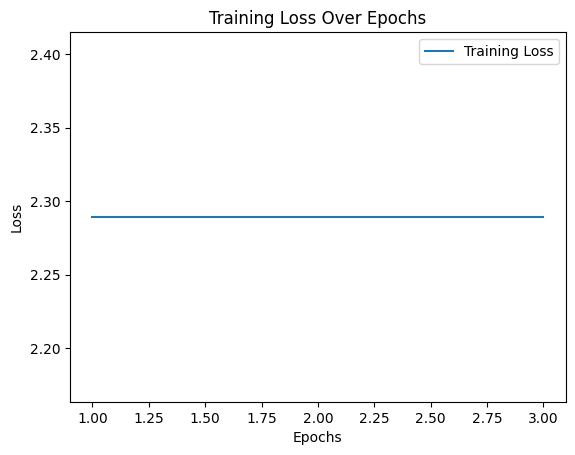

In [16]:
# Plot training loss
import matplotlib.pyplot as plt

epochs = list(range(1, int(training_args.num_train_epochs) + 1))
plt.plot(epochs, [training_loss] * len(epochs), label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [17]:
eval_results = trainer.evaluate()
print(eval_results)


100%|██████████| 13/13 [00:41<00:00,  3.20s/it]

{'eval_loss': 0.701389491558075, 'eval_runtime': 45.1205, 'eval_samples_per_second': 2.216, 'eval_steps_per_second': 0.288, 'epoch': 3.0}


In [18]:
trainer.save_model("./final_model")

In [19]:
import torch

# Save the tokenized data
torch.save(train_encodings, "train_encodings.pt")
torch.save(train_labels, "train_labels.pt")
torch.save(val_encodings, "val_encodings.pt")
torch.save(val_labels, "val_labels.pt")

# Save the tokenizer
tokenizer.save_pretrained("./final_model")

print("Tokenized data saved successfully!")


Tokenized data saved successfully!


In [20]:
# Load the tokenized data
train_encodings = torch.load("train_encodings.pt")
train_labels = torch.load("train_labels.pt")
val_encodings = torch.load("val_encodings.pt")
val_labels = torch.load("val_labels.pt")

print("Tokenized data loaded successfully!")


Tokenized data loaded successfully!


C:\Users\rajendrak\AppData\Local\Temp\ipykernel_19852\363035855.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_encodings = torch.load("train_encodings.pt")
C:\Use

In [21]:
# Test input
test_prompt = "Can you provide a html page for my My Fancy Restaurant"

# Tokenize the input
input_ids = tokenizer(test_prompt, return_tensors="pt").input_ids

# Generate output from the model
output_ids = model.generate(input_ids, max_length=512)

# Decode the output to HTML
generated_html = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Display the result
print("Prompt:", test_prompt)
print("Generated HTML:\n", generated_html)


Prompt: Can you provide a html page for my My Fancy Restaurant
Generated HTML:
 html> html html head> meta en html meta en html meta en html meta en html meta en html meta en html meta en html meta en html meta en html meta My Fancy Restaurant meta en faon./html
